In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization  
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing import image
import keras
import orjson
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
import glob
import re

Using TensorFlow backend.


In [2]:
with open('dataset_test_files.pkl', 'rb') as fp:
    df_test = pickle.load(fp)
df_test.head()

,filename,kind,defect,size,class_name,class
3,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,S,G,RS,3
4,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,S,G,RS,3
11,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,S,G,RS,3
15,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,S,G,RS,3
20,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,S,G,RS,3


In [3]:
dfs = {}
for class_name, sub_df in df_test.groupby('class_name'):
    dfs[class_name] = sub_df
    print(class_name)
    display(sub_df.head())

LC


,filename,kind,defect,size,class_name,class
51,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,L,C,M,LC,0
58,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,L,C,P,LC,0
74,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,L,C,M,LC,0
77,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,L,C,M,LC,0
87,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,L,C,P,LC,0


LS


,filename,kind,defect,size,class_name,class
21,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,L,S,G,LS,1
33,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,L,S,P,LS,1
43,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,L,S,P,LS,1
59,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,L,S,P,LS,1
71,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,L,S,P,LS,1


RC


,filename,kind,defect,size,class_name,class
34,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,C,M,RC,2
41,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,C,M,RC,2
49,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,C,M,RC,2
284,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,C,M,RC,2
443,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,C,M,RC,2


RS


,filename,kind,defect,size,class_name,class
3,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,S,G,RS,3
4,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,S,G,RS,3
11,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,S,G,RS,3
15,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,S,G,RS,3
20,D:\desenvolvimento\datasets\TRAIN1200 -1200_CO...,R,S,G,RS,3


In [4]:
# define the standalone discriminator model using GAN training hacks 
def define_discriminator(in_shape=(128,128,3)):
    model = Sequential()
    # input layer with image size of 128x128, since its a colored image it has 3 channels
    model.add(Conv2D(16, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 64x64 using strides of 2,2 and use of LeakyReLU
    model.add(Conv2D(8, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(Conv2D(16, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(Conv2D(8, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # now the image size is down to 16 x 16
    # classifier 
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # compile model learning rate is higher than generator 2e-3
    # use adam optimizer 
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model using GAN training hacks
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 16x16 image
    n_nodes = 256 * 16 * 16
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 256)))
    # upsample to 32x32, use of strides and LeakyReLU
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer, use of tanh as per hacks
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

# combined generator and discriminator model, for updating the generator
# this is alogical GAN model using above defined generator and discriminator 
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # initialize with a sequential model
    model = Sequential()
    # generator and discriminator are initialized later in the code to g_model and d_model respectively 
    # add the generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    # use of adam optimizer, learning rate is lower than discriminator 2e-4
    opt = Adam(lr=0.00002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Vamos treinar primeiro para a classe LC

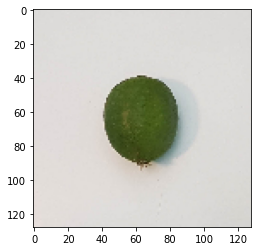

In [5]:
df = dfs['LC']
x_train = np.zeros((len(df.index), 128, 128, 3), dtype='float32')
for i, values in enumerate(df.itertuples(False)):
    img = image.load_img(values.filename, target_size=(128, 128))
    x_train[i] = (image.img_to_array(img, dtype='float32') - 127.5) / 127.5
plt.imshow((x_train[0]+1)/2)

In [6]:
n_images = x_train.shape[0]
batch_size = 64
half_batch = batch_size // 2
y_real =  np.ones((half_batch, 1))
y_fake = y_real - 1
latent_dim = 100
examples = 3
black_screen = np.zeros((2 * x_train.shape[1], examples * x_train.shape[2], x_train.shape[3]))
heigth, width = x_train.shape[1:3]
y_gan = np.ones((batch_size, 1))

In [7]:
# select real samples
# images are loaded into dataset variable using load_real_samples() function
# below function will randomly select images from dataset and spit out X and y 
# X contains images, y contains lables. (model is not trained with labels as all the images are of same label)
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.choice(n_images, n_samples, False)
    X = x_train[ix]
    return X

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = np.random.randn(n_samples, latent_dim)
    # predict outputs
    X = g_model.predict(x_input)
    return X

def normalize_image(image):
    # scale from [-1,1] to [0,255]
    return ((image + 1) * 127.5).astype(np.uint8)

def save_plot(images_real, images_fake, epoch):
    # create and save a plot of generated images
    images_real = normalize_image(images_real)
    images_fake = normalize_image(images_fake)
    for i in range(examples):
        ix = width * i
        black_screen[:heigth, ix:ix + width] = images_real[i]
        black_screen[heigth:, ix:ix + width] = images_fake[i]
    cv2.imwrite(f'data_dgan/epoch {epoch + 1:000000d}.png', black_screen)
    
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim):
    # evaluate the discriminator, plot generated images, save generator model
    # print("################# Summarize ###################")
    # prepare real samples
    X_real = generate_real_samples(dataset, half_batch)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    # print(f'>Accuracy real: {acc_real*100:.2f}%, fake: {acc_fake*100:.2f}%')
    # save plot
    save_plot(X_real[:examples], x_fake[:examples], epoch)
    # save the generator model tile file
    g_model.save(f'data_dgan/g_dgan_LC_{epoch + 1:000000d}.h5', False)
    d_model.save(f'data_dgan/d_dgan_LC_{epoch + 1:000000d}.h5', False)

In [8]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=320, start_epoch=0):
    # train the generator and discriminator
    bat_per_epo = len(dataset) // batch_size
    # manually enumerate epochs
    for i in tqdm(range(start_epoch, n_epochs)):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # print("Batch number %d" %(j+1))
            # get randomly selected 'real' samples
            X_real = generate_real_samples(dataset, half_batch)
            #print(len(X_real))  
            X_real_raw = np.array(X_real)
            # update discriminator model weights with real images
            # It is reccomended to update discriminator with seperate batches of real and fake images
            # update discriminator model with real images 
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model with fake images         
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = np.random.randn(batch_size, latent_dim)
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            # print(f'>{i+1}, f{j+1}/{bat_per_epo}, d1={d_loss1:.3f}, d2={d_loss2:.3f} g={g_loss:.3f}')
            k = cv2.waitKey(1)
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [9]:
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

In [10]:
d_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 8)        

C:\Users\Eros\venv37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [11]:
g_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 65536)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       524416    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64, 64, 128)      

In [12]:
start_epoch = 0
best_g_file = None
for file in glob.glob('data_dgan/g_dgan_LC_*.h5'):
    match = re.search(r'_(\d+).h5', file)
    if match:
        file_id = int(match[1])
        if file_id > start_epoch:
            start_epoch = file_id
            best_g_file = file
start_epoch

80

In [13]:
if best_g_file is not None:
    g_model.load_weights(best_g_file)
    d_model.load_weights(best_g_file.replace('g_dgan_', 'd_dgan_'))

In [14]:
train(g_model, d_model, gan_model, x_train, latent_dim, 100_000, start_epoch)

  0%|                                                                                        | 0/99920 [00:00<?, ?it/s]C:\Users\Eros\venv37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|                                                                             | 1/99920 [00:03<98:01:01,  3.53s/it]C:\Users\Eros\venv37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
 13%|█████████▊                                                                | 13296/99920 [49:10<5:20:23,  4.51it/s]


KeyboardInterrupt: 

In [15]:
g_model.load_weights('data_dgan/g_dgan_LC_11950.h5')

In [22]:
g_model.layers[0].get_weights()

[array([[ 0.02119978, -0.00476809, -0.02431174, ...,  0.02227372,
          0.02381894,  0.0211665 ],
        [ 0.01092719, -0.00180137,  0.00125906, ..., -0.02910084,
          0.00339402, -0.02569078],
        [ 0.01257857,  0.00112765,  0.00315014, ..., -0.01876513,
         -0.00530305, -0.00431223],
        ...,
        [ 0.01815358,  0.00614564,  0.02293662, ...,  0.00539114,
          0.00661201, -0.00602986],
        [-0.029382  ,  0.00039101,  0.04191852, ...,  0.02268522,
         -0.0240191 , -0.00867929],
        [-0.00388513, -0.00347389,  0.00213401, ..., -0.00836656,
         -0.02607686, -0.02449878]], dtype=float32),
 array([ 0.04488665, -0.01010819,  0.07353275, ...,  0.06406482,
         0.0563863 ,  0.04745485], dtype=float32)]

In [18]:
fake_lemons = generate_fake_samples(g_model, latent_dim, 32)

In [24]:
for i, image in enumerate(fake_lemons):
    cv2.imwrite(f'fake_lemon_{i}.png', normalize_image(image))